# KalmanFilter
KalmanFilter, ExtendedKalmanFilter

ForwardDiff package is required for EKF

In [1]:
using Plots, LinearAlgebra, Statistics, Distributions, Random, ForwardDiff

In [2]:
const rng = MersenneTwister(123)

MersenneTwister(UInt32[0x0000007b], Random.DSFMT.DSFMT_state(Int32[1464307935, 1073116007, 222134151, 1073120226, -290652630, 1072956456, -580276323, 1073476387, 1332671753, 1073438661  …  138346874, 1073030449, 1049893279, 1073166535, -1999907543, 1597138926, -775229811, 32947490, 382, 0]), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], UInt128[0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000  …  0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x0000000000000

## define constructor of KalmanFilter
define Equation of state and Equation of observation as follows:
$$
\boldsymbol{x}_{k} = A_k \boldsymbol{x}_{k} + B_k \boldsymbol{u}_{k} +  \boldsymbol{w}_{k}
$$
$$
\boldsymbol{z}_{k} = C_k \boldsymbol{x}_{k} + \boldsymbol{v}_{k}
$$
$ \boldsymbol{w}_{k} $ and $ \boldsymbol{v}_{k} $ is gaussian noise:
$$
\boldsymbol{w}_{k} \sim  N(0, Q_k)
$$
$$
\boldsymbol{v}_{k} \sim N(0, R_k)
$$

In [3]:
# constructor of time-invariant system (F,G,H,Q,R is constant)
mutable struct KF
    # system dynamics matrices
    A::Array{Float64}       # EOS
    B::Array{Float64}       # controll
    C::Array{Float64}       # EOO
    Q::Array{Float64}       # Covariace matrix of drive noise
    R::Array{Float64}       # COvariance matix of observation noise
    # old state of system (or initial state at construction)
    x_old::Vector{Float64}
    P_old::Array{Float64}
end
# in case you consider the time-variant system, you have to access the members of this struct consequently
function KF(kf::KF, A::Matrix{Float64}, B::Matrix{Float64}, C::Matrix{Float64}, Q::Matrix{Float64}, R::Matrix{Float64})
    # update time-variant system dynamics
    kf.A = A
    kf.B = B
    kf.C = C
    kf.Q = Q
    kf.R = R
    return kf
end
function KF(kf::KF, x_old::Vector{Float64}, P_old::Matrix{Float64})
    kf.x_old = x_old
    kf.P_old = P_old
end

KF

In [4]:
# Equation of State
KF_EoS(kf::KF, x::Vector{Float64}; w=zeros(length(x)), u=zeros(length(x))) = kf.A*x + kf.B*u + w
# Equation of Observation
KF_EoO(kf::KF, x::Vector{Float64}; v=zeros(length(kf.C*x))) = kf.C*x + v

KF_EoO (generic function with 1 method)

## update of state
Prediction of state:
$$
\hat{\boldsymbol{x}}_{k|k-1} = A_k \hat{\boldsymbol{x}}_{k-1|k-1} + B_k \boldsymbol{u}_{k}  \qquad \textrm{: prediction of state}
$$
$$
P_{k|k-1} = A_k P_{k-1|k-1} A_k^T + Q_k  \quad \textrm{: prediction of error matrix}
$$

Update of state:
$$
\boldsymbol{e}_{k} = \boldsymbol{z}_{k} - C_k \hat{\boldsymbol{x}}_{k|k-1}    \quad \textrm{: innovation}
$$
$$
S_k = R_k + C_k P_{k|k-1} C_k^T   \quad \textrm{: covariance matrix of innovation}
$$
$$
K_k = P_{k|k-1} C_k^T S_k^{-1}      \quad \textrm{: optimal Kalman gain}
$$
$$
\hat{\boldsymbol{x}}_{k|k} = \hat{\boldsymbol{x}}_{k|k-1}  + K_k\boldsymbol{e}_{k}     \quad \textrm{: updated state prediction}
$$
$$
P_{k|k} = (I-K_kC_k) P_{k|k-1}    \quad \textrm{: updated error matrix}
$$

In [5]:
# Estimation of Stable dynamics (using linear kalman filter) 
# with controll varuable
# Update
function KFUpdate(kf::KF, x::Vector{Float64}, u::Vector{Float64})
    @assert length(u)==length(kf.A*kf.x_old)
    # Prediction of older filter
    x_predicted = KF_EoS(kf, kf.x_old, u=u)
    P_predicted = kf.A * kf.P_old * transpose(kf.A) + kf.Q
    
    # update filter
    C_T = transpose(kf.C)
    e = x - KF_EoO(kf, x_predicted)
    S = kf.R + kf.C * P_predicted * C_T
    Sinv = inv(S)
    K = P_predicted * C_T * Sinv
    x_updated = x_predicted + K*e
    nm = length(kf.x_old)
    eye = Matrix{Float64}(I, nm, nm)
    P_updated = (eye - K*kf.C) * P_predicted
    
    kf.x_old = x_updated
    kf.P_old = P_updated
    return x_updated, P_updated
end
# without controll
function KFUpdate(kf::KF, x::Vector{Float64})
    # Prediction of older filter
    x_predicted = KF_EoS(kf, kf.x_old)
    P_predicted = kf.A * kf.P_old * transpose(kf.A) + kf.Q
    
    # update filter
    C_T = transpose(kf.C)
    e = x - KF_EoO(kf, x_predicted)
    S = kf.R + kf.C * P_predicted * C_T
    Sinv = inv(S)
    K = P_predicted * C_T * Sinv
    x_updated = x_predicted + K*e
    nm = length(kf.x_old)
    eye = Matrix{Float64}(I, nm, nm)
    P_updated = (eye - K*kf.C) * P_predicted
    
    kf.x_old = x_updated
    kf.P_old = P_updated
    return x_updated, P_updated
end

KFUpdate (generic function with 2 methods)

In [6]:
# Estimation of Stable dynamics (using linear kalman filter) 
# with controll varuable
# Update
function KFPropagate(kf::KF, x::Vector{Float64}, u::Vector{Float64})
    @assert length(u)==length(kf.A*kf.x_old)
    # Prediction of older filter
    x_predicted = KF_EoS(kf, kf.x_old, u=u)
    P_predicted = kf.A * kf.P_old * transpose(kf.A) + kf.Q
    
    kf.x_old = x_predicted
    kf.P_old = P_predicted
    return x_predicted, P_predicted
end
# without controll
function KFPropagate(kf::KF, x::Vector{Float64})
    # Prediction of older filter
    x_predicted = KF_EoS(kf, kf.x_old)
    P_predicted = kf.A * kf.P_old * transpose(kf.A) + kf.Q
    
    kf.x_old = x_predicted
    kf.P_old = P_predicted
    return x_predicted, P_predicted
end

KFPropagate (generic function with 2 methods)

## example : state estimation of moving trocco
assumptions:
- no control
- time invariant
- accurate initial state

state is represented as :
$$
\boldsymbol{x}_k = 
 \left[\begin{array}{c}
            x_k \\
            \dot{x}_k \\
        \end{array}\right]
$$
acceralation $ a_k \sim N(0,\sigma_a) $ is given between time $k$ and  $k-1$. System dynamics is represented  as :
$$
\boldsymbol{x}_k = A \boldsymbol{x}_{k-1} + G a_k
$$
$$
A = 
\left[\begin{array}{cc}
            1 & \Delta t\\
            0 & 1\\
        \end{array}\right]
$$
$$
G = 
 \left[\begin{array}{c}
            \frac{\Delta t^2}{2} \\
             \Delta t\\
         \end{array}\right]  
$$
$$
a_k \sim N(0, \sigma_a) 
$$
$$
Q = Cov(G a_k) = \sigma_a^2 \times
\left[\begin{array}{cc}
            \frac{\Delta t^4}{4} & \frac{\Delta t^3}{2}\\
            \frac{\Delta t^3}{2} & \Delta t^2\\
        \end{array}\right]
$$
position $ z_k $ is observed every $\Delta t$.  $ z_k $ is represented by observation error $v_k $ as:
$$
z_k = C \boldsymbol{x}_{k}+\boldsymbol{v}_{k}
$$
$$
C = \left[\begin{array}{cc}
            1 & 0\\
        \end{array}\right]
$$
$$
v_k \sim N(0, \sigma_z)
$$
$$
R = 
\mathrm{E}\left(\boldsymbol{v}_{k} \boldsymbol{v}_{k}^{\mathrm{T}}\right)=\left[\sigma_{z}^{2}\right]
$$


In [7]:
function KF_trocco()
    x₀ = [0., 0.]
    P₀ = [10 0. ; 0. 10.]
    σₐ = 1.
    σ₀ = 1.
    Δt = 0.1              # [sec]
    tstep_observation = 5
    A = [1. Δt ; 0. 1.]
    B = [1. 0.; 0. 1.]      # not specified because u is zero vector
    G = [Δt^2/2, Δt]
    Q = σₐ^2 * [Δt^4/4 Δt^3/2; Δt^3/2 Δt^2]
    C = [1 0]
    R = [σ₀^2]
    kf = KF(A, B, C, Q, R, x₀, P₀)
    
    tspan = 0.:Δt:10.
    k = collect(tspan)
    xtrue = zeros(length(k),2)       # true value
    state = zeros(length(k),2)       # inner state of KF
    estim = zeros(length(k),2)      # estimated state of KF
    obser = zeros(length(k),1)     # observed state observed state
    Pmax = zeros(length(k),1)     # max value of P
    
    xtrue[1,:] = x₀
    Pmax[1] = maximum(P₀)
    obser[1,:] = KF_EoO(kf, xtrue[1,:], v=[randn(rng)])
    estim[1,:], newP = KFPropagate(kf, obser[1,:])

    for ind in range(2,stop=length(k))
        xtrue[ind,:] = KF_EoS(kf, xtrue[ind-1,:], w=G*randn(rng))
        obser[ind,:] = KF_EoO(kf, xtrue[ind,:], v=[randn(rng)])
        if ind%tstep_observation==0
            estim[ind,:], newP = KFUpdate(kf, obser[ind,:])
        else
            estim[ind,:], newP = KFPropagate(kf, obser[ind,:])
        end
        Pmax[ind] = maximum(newP)
    end
    return xtrue, estim, obser, Pmax
end

KF_trocco (generic function with 1 method)

In [8]:
@time xtrue, estim, obser, Pmax = KF_trocco()

  2.751405 seconds (6.44 M allocations: 315.416 MiB, 6.75% gc time)


([0.0 0.0; 0.0102409 0.204818; … ; 4.70228 0.59259; 4.7607 0.57599], [0.0 0.0; 0.0 0.0; … ; 5.40758 1.13849; 5.52143 1.13849], [1.19027; 1.15289; … ; 5.27755; 5.10729], [10.0; 10.4003; … ; 0.376915; 0.414153])

## Result
### The position

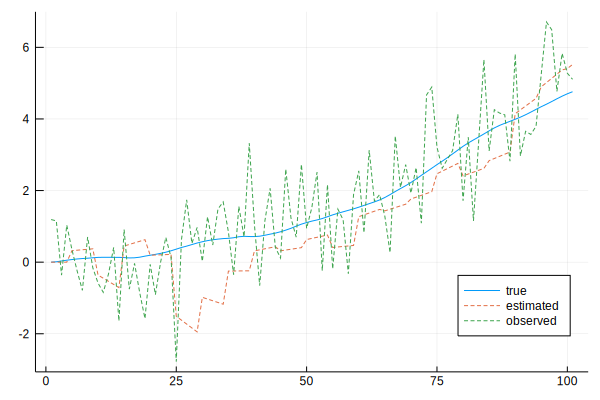

In [9]:
plot(xtrue[:,1], label="true", legend=:bottomright)
plot!(estim[:,1], linestyle=:dash, label="estimated")
plot!(obser[:,1], linestyle=:dash, label="observed")

### The verocity

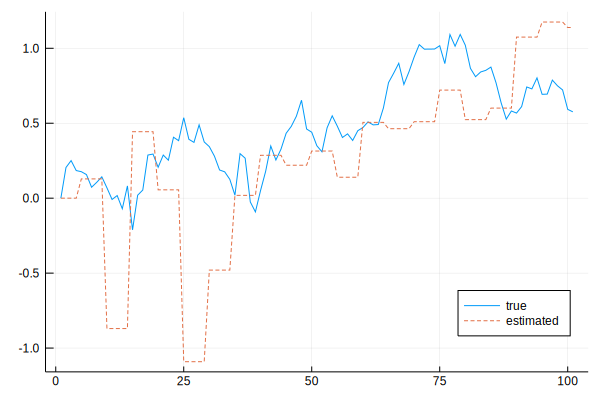

In [10]:
plot(xtrue[:,2], label="true", legend=:bottomright)
plot!(estim[:,2], linestyle=:dash, label="estimated")

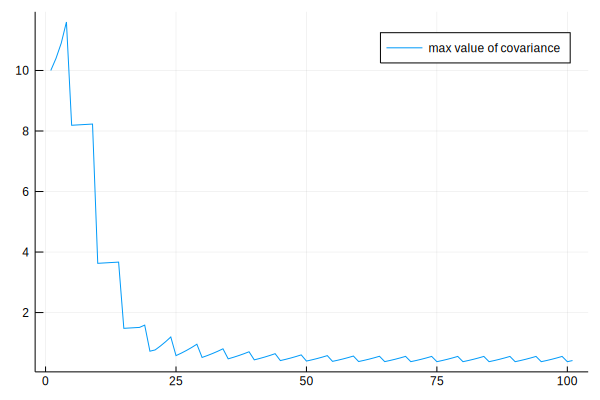

In [11]:
plot(Pmax, label="max value of covariance")

In [12]:
function KF_2D()
    x₀ = [0., 0.]
    P₀ = [10. 0. ; 1. 10.]
    σₐ = 1.
    σ₀ = 1.
    Δt = 0.1              # [sec]
    tstep_observation = 5
    A = [1. 0. ; 0. 1.]
    B = [1. 0.; 0. 1.]      # not specified because u is zero vector
    G = [1. 0.;0. 1.]
    Q = σₐ^2 * [1 1; 1 1]
    C = [1 0; 0 1]
    R = [σ₀^2 0; 0 σ₀^2]
    kf = KF(A, B, C, Q, R, x₀, P₀)
    
    u = [0.5,0.5]      # verocity
    
    tspan = 0.:Δt:10.
    k = collect(tspan)
    xtrue = zeros(length(k),2)       # true value
    state = zeros(length(k),2)       # inner state of KF
    estim = zeros(length(k),2)      # estimated state of KF
    obser = zeros(length(k),2)     # observed state observed state
    Pmax = zeros(length(k),1)     # max value of P
    
    xtrue[1,:] = x₀
    Pmax[1] = maximum(P₀)
    obser[1,:] = KF_EoO(kf, xtrue[1,:], v=[randn(rng), randn(rng)])
    estim[1,:], newP = KFPropagate(kf, obser[1,:], u)
    
    for ind in range(2,stop=length(k))
        xtrue[ind,:] = KF_EoS(kf, xtrue[ind-1,:], w=G*[randn(rng),randn(rng)], u=u)
        obser[ind,:] = KF_EoO(kf, xtrue[ind,:], v=[randn(rng), randn(rng)])
        if ind%tstep_observation==0
            estim[ind,:], newP = KFUpdate(kf, obser[ind,:],u)
        else
            estim[ind,:], newP = KFPropagate(kf, obser[ind,:],u)
        end
        Pmax[ind] = maximum(newP)
    end
    return xtrue, estim, obser, Pmax
end

KF_2D (generic function with 1 method)

In [13]:
@time xtrue, estim, obser, Pmax=KF_2D()

  0.390608 seconds (1.00 M allocations: 51.418 MiB, 7.38% gc time)


([0.0 0.0; 0.393965 -0.791179; … ; 53.2294 46.5082; 52.7045 45.107], [0.5 0.5; 1.0 1.0; … ; 51.0039 49.0263; 51.5039 49.5263], [1.60431 -0.0246589; 0.0559798 -0.968272; … ; 53.2599 46.9644; 50.9235 44.4035], [10.0; 12.0; … ; 0.482909; 1.48291])

## Result
### The estimate of Position

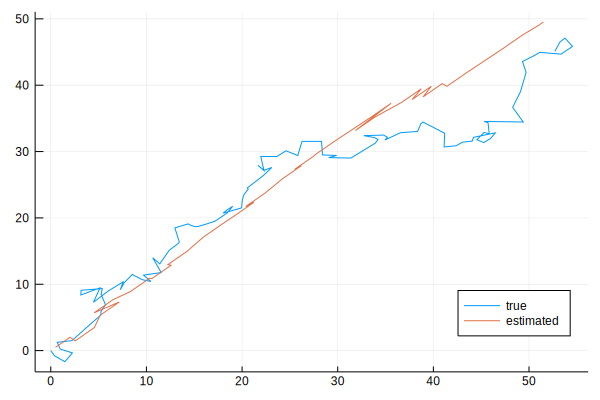

In [14]:
plot(xtrue[:,1], xtrue[:,2], label="true", legend=:bottomright)
plot!(estim[:,1], estim[:,2], label="estimated")

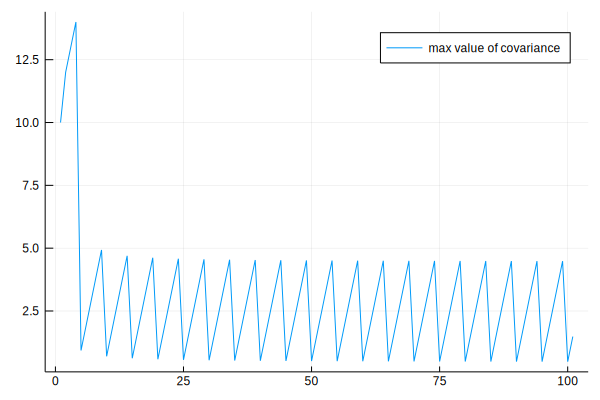

In [15]:
plot(Pmax, label="max value of covariance")

## References
- https://ja.wikipedia.org/wiki/カルマンフィルター
- http://koukyo1213.hatenablog.com/entry/KalmanFilter